In [20]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [21]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [22]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [23]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=29,
        output_chunk_length=1,
        num_filters=50,
        kernel_size=8,
        num_layers=3,
        dilation_base=4,
        weight_norm=True,
        n_epochs=100,
        batch_size=107,
        dropout=0.10987578257441336,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.004525867812805064, "weight_decay": 0.00015619537785532893}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.032
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    5.778887    2.403932    1.872383  0.884582   
Precipitation_accumulated      0.241063    0.490981    0.471634  0.617569   
Humidity                      33.257369    5.766920    4.371244  0.894094   
Wind_Speed_kmh                 0.827343    0.909584    0.759492 -0.957505   
Soil_Moisture              36242.037325  190.373415  133.370326  0.941593   
Soil_Temperature              14.681802    3.831684    3.178848  0.798231   
Wind_Dir_Sin                   0.340813    0.583792    0.452571 -0.066448   
Wind_Dir_Cos                   0.481598    0.693973    0.528514 -0.244996   

                                SMAPE  
Temperature                 12.289317  
Precipitation_accumulated   14.965688  
Humidity                     6.789574  
Wind_Speed_kmh             107.684730  
Soil_Moisture   

Metric val_loss improved. New best score: 8.721
Metric val_loss improved by 0.212 >= min_delta = 0.001. New best score: 8.509
Metric val_loss improved by 0.281 >= min_delta = 0.001. New best score: 8.228
Metric val_loss improved by 0.608 >= min_delta = 0.001. New best score: 7.620
Metric val_loss improved by 0.564 >= min_delta = 0.001. New best score: 7.056
Metric val_loss improved by 0.567 >= min_delta = 0.001. New best score: 6.489
Metric val_loss improved by 0.461 >= min_delta = 0.001. New best score: 6.028
Metric val_loss improved by 0.270 >= min_delta = 0.001. New best score: 5.758
Metric val_loss improved by 0.095 >= min_delta = 0.001. New best score: 5.663
Metric val_loss improved by 0.144 >= min_delta = 0.001. New best score: 5.520
Metric val_loss improved by 0.180 >= min_delta = 0.001. New best score: 5.340
Metric val_loss improved by 0.124 >= min_delta = 0.001. New best score: 5.216
Metric val_loss improved by 0.122 >= min_delta = 0.001. New best score: 5.094
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                1.990840e+02     14.109712     11.713706   
Precipitation_accumulated  2.959017e+03     54.396850     46.434734   
Humidity                   1.447861e+05    380.507744    324.573563   
Wind_Speed_kmh             1.823359e+03     42.700802     36.556491   
Soil_Moisture              4.686913e+08  21649.278674  18475.173401   
Soil_Temperature           2.250547e+03     47.439930     40.572687   
Wind_Dir_Sin               7.286115e+02     26.992805     23.082064   
Wind_Dir_Cos               3.632058e+02     19.057959     16.344345   

                                    R2       SMAPE  
Temperature                  -4.738959   51.239679  
Precipitation_accumulated     0.925283   13.187057  
Humidity                  -1153.103170  147.358940  
Wind_Speed_kmh            -5563.547816  156.485149  
Soil_

Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.008
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    3.162870    1.778446    1.386271  4.313866e-01   
Precipitation_accumulated    750.871720   27.402039   24.266097 -6.378349e+06   
Humidity                       7.345904    2.710333    2.022848  5.734556e-01   
Wind_Speed_kmh                 0.010693    0.103406    0.081958          -inf   
Soil_Moisture              22584.787998  150.282361  100.054963 -1.587762e+01   
Soil_Temperature               5.368166    2.316930    1.963646  1.497809e-01   
Wind_Dir_Sin                   0.013947    0.118097    0.098219          -inf   
Wind_Dir_Cos                   0.149454    0.386593    0.319211          -inf   

                                SMAPE  
Temperature                  9.353533  
Precipitation_accumulated    5.124655  
Humidity                     2.292807  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encount

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   1.542204   1.241855   0.635604    -1.735564   
Precipitation_accumulated   256.964111  16.030100   9.938527 -7775.482382   
Humidity                     13.019798   3.608296   3.183553    -0.334324   
Wind_Speed_kmh                0.050601   0.224947   0.127245         -inf   
Soil_Moisture              4427.993813  66.543173  54.001951     0.871802   
Soil_Temperature              1.466014   1.210791   0.666987    -5.480361   
Wind_Dir_Sin                  0.002886   0.053725   0.036880         -inf   
Wind_Dir_Cos                  0.004778   0.069123   0.054062         -inf   

                                SMAPE  
Temperature                  8.102861  
Precipitation_accumulated    2.198033  
Humidity                     3.483095  
Wind_Speed_kmh             200.000000  
Soil_Moisture   

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.601351    1.265445    1.057975    0.325743   
Precipitation_accumulated    147.390615   12.140454    9.216109 -517.295196   
Humidity                       7.491537    2.737067    2.223891    0.839352   
Wind_Speed_kmh                 0.013884    0.117830    0.084648   -5.676410   
Soil_Moisture              17035.712941  130.520929  121.553444   -1.117251   
Soil_Temperature               0.652783    0.807950    0.522944    0.597169   
Wind_Dir_Sin                   0.019859    0.140923    0.069477    0.656654   
Wind_Dir_Cos                   0.027082    0.164565    0.093055    0.693685   

                                SMAPE  
Temperature                 14.997891  
Precipitation_accumulated    2.042531  
Humidity                     2.682135  
Wind_Speed_kmh             189.242279 

Metric val_loss improved. New best score: 0.023
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE         R2  \
Temperature                    1.284433    1.133328   0.810354   0.863178   
Precipitation_accumulated     83.608100    9.143746   6.686303 -71.218593   
Humidity                       5.963832    2.442096   1.685350   0.948288   
Wind_Speed_kmh                 0.462504    0.680076   0.469302   0.702717   
Soil_Moisture              14724.749759  121.345580  57.948491   0.988479   
Soil_Temperature               1.440440    1.200183   0.886807   0.713824   
Wind_Dir_Sin                   0.317435    0.563413   0.440549   0.335500   
Wind_Dir_Cos                   0.286887    0.535618   0.404426   0.412092   

                                SMAPE  
Temperature                 26.136977  
Precipitation_accumulated    1.464423  
Humidity                     1.872800  
Wind_Speed_kmh              83.542009  
Soil_Moisture   

Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   1.954460   1.398020   1.052884    0.927765   
Precipitation_accumulated    79.665699   8.925564   7.694347 -271.589411   
Humidity                     13.358334   3.654905   2.836290    0.911582   
Wind_Speed_kmh                0.480968   0.693519   0.509337    0.599759   
Soil_Moisture              5670.624093  75.303546  57.745144    0.041159   
Soil_Temperature              0.843923   0.918653   0.704491    0.924314   
Wind_Dir_Sin                  0.410508   0.640709   0.540780    0.234315   
Wind_Dir_Cos                  0.307028   0.554101   0.453982    0.096671   

                                SMAPE  
Temperature                 10.526494  
Precipitation_accumulated    1.669872  
Humidity                     3.508812  
Wind_Speed_kmh              51.899299  
Soil_Moisture            

In [24]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=8, num_filters=50, num_layers=3, dilation_base=4, weight_norm=True, dropout=0.10987578257441336, model_name=model_1, input_chunk_length=29, output_chunk_length=1, n_epochs=100, batch_size=107, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f2b2c11e750>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.004525867812805064, 'weight_decay': 0.00015619537785532893})

In [25]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


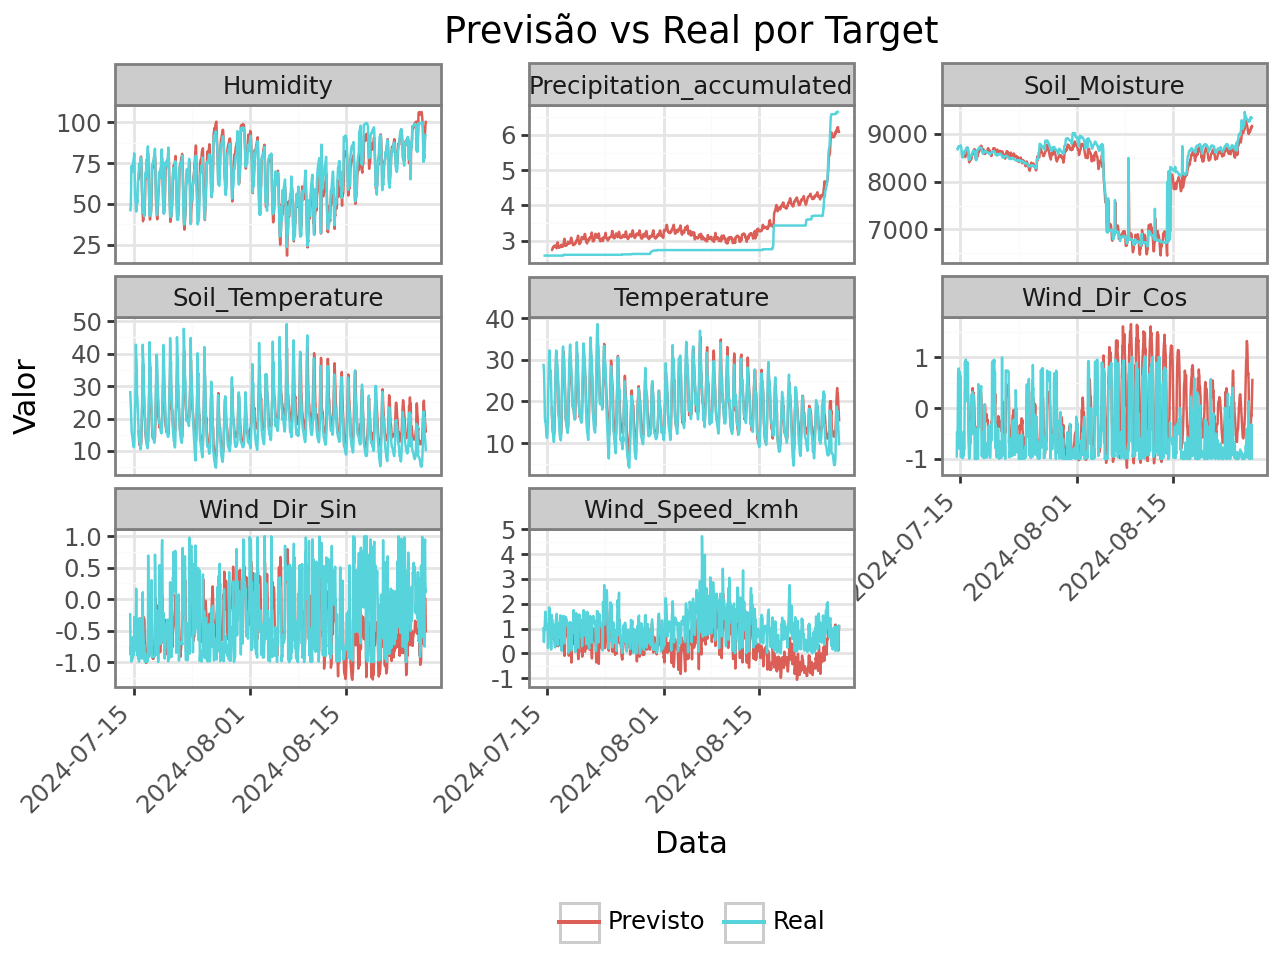

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [26]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [27]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

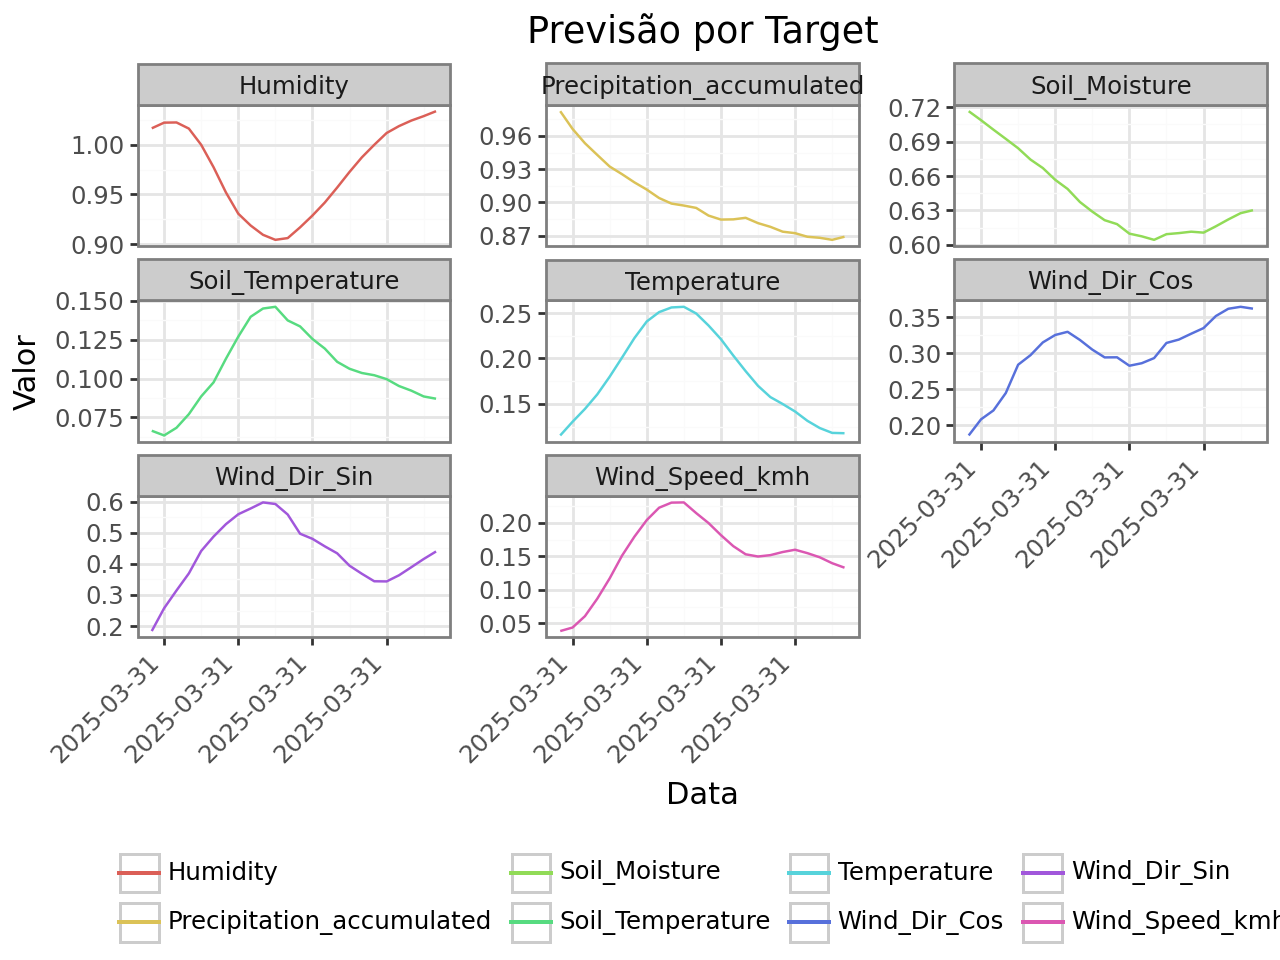

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [28]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [29]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)